In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Inputs

In [2]:
# data
c = 5; d = 2*c + 1 # number of "clusters" in the data
n = 1000
noise = .5
test_size = .2
val_size = .3

# model
# modelName, model_nbFeat, model_h = 'LinearNet', None, None
# modelName, model_nbFeat, model_h = 'FCNet', 10, None
modelName, model_nbFeat, model_h = 'DeepNet', 10, 30

# seed
seed = 10
def set_seed(seed = 8):
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(seed)

## Data

In [3]:
# synthetic data with c blue clusters
U, y, m = [], [], int(n/d)
for i in range(d):
    im = i%2
    if im == 0:
        U.extend(list(i/d+np.random.rand(m)/d))
    else:
        U.extend(list((i-noise/2)/d+np.random.rand(m)*(1+noise)/d))
    y.extend([im] * m)
U, y = np.array(U), np.array(y)
X = 2*U-1

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y,
                                                          test_size=test_size,
                                                          random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval,
                                                  test_size=val_size,
                                                  random_state=seed)

# grid (for plots)
grid = torch.linspace(-1, 1, 50, dtype=torch.float).view(-1,1)

Text(0.5, 1.0, 'toy data')

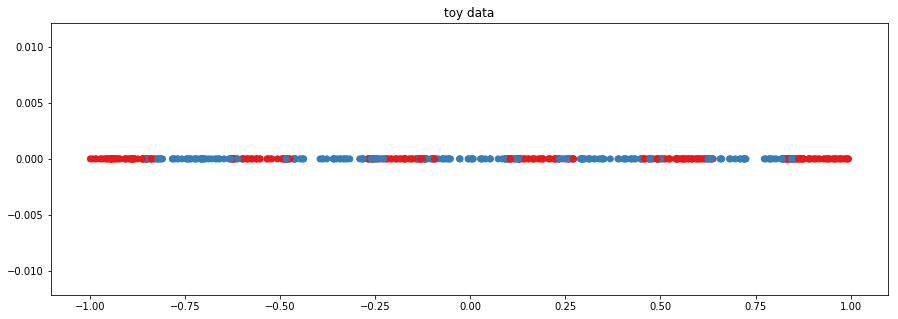

In [4]:
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)
ax.scatter(X_train, 0*y_train, c=cm.Set1(y_train), marker = 'o')
ax.set_title('toy data')

## Experiments

In [5]:
# define model
class Net(nn.Module):
    
    inputDim = 1
    outputDim = 1
    
    def __init__(self, name, nbFeat=None, h=None):
        super().__init__()
        
        self.name = name
        self.nbFeat = nbFeat
        
        if self.name == 'LinearNet':
            self.nbFeat = Net.inputDim
            self.nbEpochs = 100
            self.lr = 0.001 # use RMSProp
            
        elif self.name == 'FCNet':
            if nbFeat is None:
                raise ValueError('nbFeat cannot be None for this net')
            self.fc1 = nn.Linear(Net.inputDim, self.nbFeat)
            self.nbEpochs = 1000
            self.lr = 0.001 # use RMSProp
            
        elif self.name == 'DeepNet':
            if nbFeat is None or h is None:
                raise ValueError('nbFeat and h cannot be None for this net')
            self.fc1 = nn.Linear(Net.inputDim, h)
            self.fc2 = nn.Linear(h, h)
            self.fc3 = nn.Linear(h, h)
            self.fc4 = nn.Linear(h, self.nbFeat)
            self.nbEpochs = 1000
            self.lr = 0.001 # use RMSProp
        else:
            raise ValueError('unkown model name: {}'.format(self.name))

        self.w = nn.Linear(self.nbFeat, Net.outputDim) # initializes at random
        
    def featurize(self, x):
        for name,layer in self.named_children():
            if 'fc' in name:
                x = torch.relu(layer(x))
        return x
    
    def score(self, x):
        x = self.featurize(x)
        x = self.w(x)
        return x
    
    def forward(self, x):
        x = torch.sigmoid(self.score(x))
        return x

In [6]:
# instanciate model and setup
model = Net(modelName, model_nbFeat, model_h)

lossfn = nn.BCELoss() # BinaryCrossEntropy
# optimizer = optim.SGD(model.parameters(), lr=0.1) # using a better optimizer DOES make a difference
optimizer = optim.RMSprop(model.parameters(),
                          lr=model.lr,
                          alpha=0.99,
                          eps=1e-08,
                          weight_decay=0,
                          momentum=0.9,
                          centered=False)
# optimizer = optim.Adam(model.parameters(),
#                        lr=0.01,
#                        betas=(0.9, 0.999),
#                        eps=1e-08,
#                        weight_decay=0,
#                        amsgrad=False)
for p in model.named_children():
    print(p)

('fc1', Linear(in_features=1, out_features=30, bias=True))
('fc2', Linear(in_features=30, out_features=30, bias=True))
('fc3', Linear(in_features=30, out_features=30, bias=True))
('fc4', Linear(in_features=30, out_features=10, bias=True))
('w', Linear(in_features=10, out_features=1, bias=True))


[1] error: 0.6903975009918213
[11] error: 0.7092709541320801
[21] error: 0.6657750606536865
[31] error: 0.6514176726341248
[41] error: 0.637052595615387
[51] error: 0.6213828325271606
[61] error: 0.6096131205558777
[71] error: 0.5960682034492493
[81] error: 0.5894799828529358
[91] error: 0.5821114778518677
[101] error: 0.5860328674316406
[111] error: 0.5787068009376526
[121] error: 0.57433021068573
[131] error: 0.5742167830467224
[141] error: 0.568536102771759
[151] error: 0.5660133957862854
[161] error: 0.5664123892784119
[171] error: 0.5670108199119568
[181] error: 0.570707380771637
[191] error: 0.5594093203544617
[201] error: 0.5597655773162842
[211] error: 0.5589010119438171
[221] error: 0.5592496395111084
[231] error: 0.5430154204368591
[241] error: 0.5385181307792664
[251] error: 0.5322911739349365
[261] error: 0.5341924428939819
[271] error: 0.5347211360931396
[281] error: 0.5196347832679749
[291] error: 0.519572913646698
[301] error: 0.5129406452178955
[311] error: 0.5101657509

Text(0.5, 1.0, 'train loss')

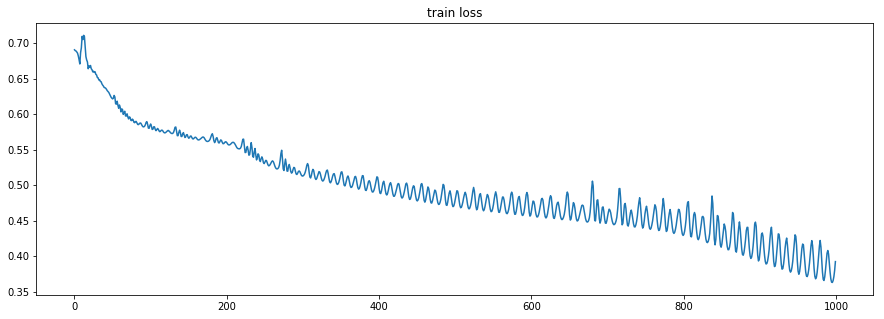

In [7]:
# train model
_X = torch.tensor(X_train, dtype=torch.float).view(-1, 1) # reshape with one column
_y = torch.tensor(y_train, dtype=torch.float).view(-1, 1) # reshape with one column
_aloss = []

for epoch in range(model.nbEpochs):  # loop over the dataset multiple times
  
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    # no minibatch here: take whole dataset
    fX = model(_X)
    loss = lossfn(fX, _y); _aloss.append(loss)
    loss.backward()
    optimizer.step()
        
    # print statistics
    if epoch % 10 == 0:
        print('[{}] error: {}'.format(epoch + 1, loss))

fX = model(_X)
loss = lossfn(fX, _y)
print('[last] error: {}'.format(loss))

print('Finished Training')

f = plt.figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)
ax.plot(_aloss)
ax.set_title('train loss')

Text(0.5, 1.0, 'prediction')

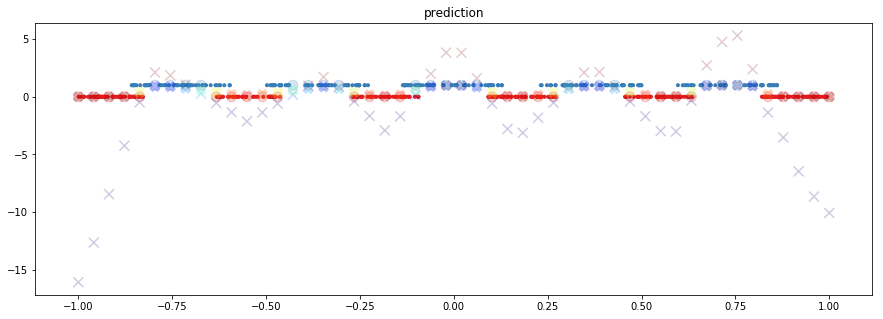

In [8]:
_gridHatScore = model.score(grid).detach().numpy().flatten()
_gridHat = model(grid).detach().numpy().flatten()
_gridHatClass = [int(x+0.5) for x in _gridHat]

f = plt.figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)
ax.scatter(X_train, y_train, c=cm.Set1(y_train), marker = '.')
ax.scatter(grid, _gridHatClass, c=cm.Set1(_gridHatClass), s=100, marker = 'o', alpha=.2)
ax.scatter(grid, _gridHatScore, c=cm.jet(_gridHatScore), s=100, marker = 'x', alpha=.2)
ax.scatter(grid, _gridHat, c=cm.jet(1-_gridHat), s=100, marker = 'X', alpha=.2)
ax.set_title('prediction')

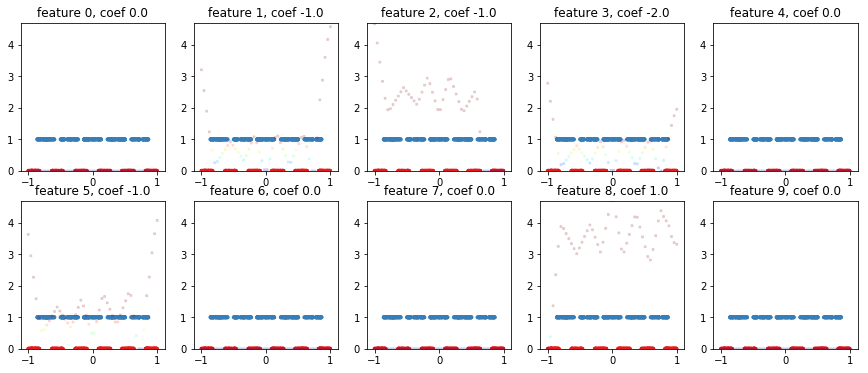

In [9]:
_gridHatFeat = model.featurize(grid).detach().numpy()

K = _gridHatFeat.shape[1]
M = np.max(_gridHatFeat)
nc = 5
nr = int(np.ceil(K/nc))

f = plt.figure(figsize=(3*nc,3*nr))
for k in range(K):
    tmp = _gridHatFeat[:,k]
    
    ax = f.add_subplot(nr,nc,1+k)
    ax.scatter(X_train, y_train, c=cm.Set1(y_train), marker = '.')
    ax.scatter(grid, tmp, c=cm.jet(tmp), s=5, marker = 'x', alpha=.2)
    ax.set_title('feature {}, coef {}'.format(k, np.round(model.w.weight.data[0,k]),3))
    ax.set_ylim((0,M))